In [1]:
### OLS regression attempt ###

import numpy as np
from statsmodels.api import OLS
import statsmodels.tools.tools
import datetime
import os
import h5py
from pandas import DataFrame
from matplotlib import pyplot as plt
from fair_scm import *

#import and rebaseline the observations ready for plotting
base_low=1850.
base_high=1900.
com_ref_low=1880.
com_ref_high=2017.
temp_freq='mon'

## Import the temperature observation datasets ##
#Specify the GMST best-estimate temperature timeseries files 
gmst_files = {'HadCRUT4':'./Data/HadCRUT.4.6.0.0.monthly_ns_avg.txt',
'GISTEMP':'./Data/GLB.Ts+dSST.csv',
'NOAA':'./Data/aravg.mon.land_ocean.90S.90N.v4.0.1.201803.asc',
'Berkeley':'./Data/Land_and_Ocean_complete.txt',
'HadCRUT4-CW':'./Data/had4_krig_v2_0_0.txt'}

gmst_names = gmst_files.keys()
years_com = np.arange(1850. + 1./24,1850. + 1./24 + (2020)*1./12,1.0/12)[:-1]
gmst = {}

for key in gmst_names:
    
    if key in ['HadCRUT4','HadCRUT4-CW']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,1]
        years = years_com[:len(temps)]

    if key in ['GISTEMP']:
        f_giss = open(gmst_files[key],'r')
        temps = []
        counter = 0
        for line in f_giss:
          if counter>=2:
              temps.extend([float(f) for f in line.split(',')[1:13] if f != '***'])
          counter = counter + 1
        temps=np.array(temps)
        years = years_com[years_com>1880.][:len(temps)]

    if key in ['NOAA']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,2]
        years = years_com[years_com>1880.][:len(temps)]

    if key in ['Berkeley']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,2]
        years = years_com[:len(temps)]


    gmst[key] = {'Temp':temps,'Years':years}

#Set the datasets to a common reference period        
hc_ref = np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=com_ref_low,
                gmst['HadCRUT4']['Years']<(com_ref_high+1))]) - np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=base_low,
                                                gmst['HadCRUT4']['Years']<(base_high+1))])
for key in gmst_names:
    gmst[key]['Temp'] = gmst[key]['Temp'][gmst[key]['Years'] < 2018.]
    gmst[key]['Years'] = gmst[key]['Years'][gmst[key]['Years'] < 2018.]
    #Express relative to a common base period
    gmst[key]['Temp'] = gmst[key]['Temp'] - np.mean(gmst[key]['Temp'][np.logical_and(gmst[key]['Years']>=com_ref_low,
                                                              gmst[key]['Years']<(com_ref_high+1))])
    #Set NOAA and GISTEMP datasets relative to HadCRUT4 value over the base period 
    if key in ['NOAA','GISTEMP']:
        gmst[key]['Temp'] = gmst[key]['Temp'] + hc_ref
    else: 
        gmst[key]['Temp'] = gmst[key]['Temp'] - np.mean(gmst[key]['Temp'][np.logical_and(gmst[key]['Years']>=base_low,
                                                                              gmst[key]['Years']<(base_high+1))])

obs_max = np.zeros_like(gmst['HadCRUT4']['Years'])
obs_min = np.zeros_like(gmst['HadCRUT4']['Years'])
obs_mean = np.zeros_like(gmst['HadCRUT4']['Years'])
for y in range(0,len(gmst['HadCRUT4']['Years'])): 
    year_vals =[]
    #Loop over AR5 datasets and HadCRUT4-CW
    for ob in ['HadCRUT4','NOAA','GISTEMP','HadCRUT4-CW']:
        val = gmst[ob]['Temp'][gmst[ob]['Years']==gmst['HadCRUT4']['Years'][y]]
        if len(val)>0:
            year_vals.append(val)
    obs_max[y] = np.max(year_vals)
    obs_min[y] = np.min(year_vals)
    obs_mean[y] = np.mean(year_vals)

gmst['Temp-max'] = obs_max
gmst['Temp-min'] = obs_min
gmst['Temp-mean'] = obs_mean

/Users/stuartjenkins/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def calc_gwi(obs,obs_years,reg_type='mon',base_low=1850.,base_high=1900):
    
    #Express the observations relative to the base period 
    obs = obs - np.mean(obs[np.logical_and(obs_years>=base_low,obs_years<(base_high+1))])

    #Load the best estimate forcings from Piers
    forc_file = './Data/Annualforcings_Mar2014_GHGrevised.txt'
    data = np.genfromtxt(forc_file,skip_header=4)
    years = data[:,0]
    tot_forc = data[:,13]
    ant_forc = data[:,14]

    #Integrate anthropogenic and natural forcing with standard FAIR parameters
    C, t_nat = fair_scm(other_rf=tot_forc-ant_forc)
    C, t_anthro = fair_scm(other_rf=ant_forc)
    #Express relative to the centre of the base period
    t_nat = t_nat - np.mean(t_nat[np.logical_and(years>=base_low,years<base_high+1)])
    t_anthro = t_anthro - np.mean(t_anthro[np.logical_and(years>=base_low,years<base_high+1)])

    #Interpolate the annual forced responses to the grid of the observed data
    if reg_type !='mon':
        t_nat = np.interp(obs_years+0.5, years+0.5, t_nat)
        t_anthro = np.interp(obs_years+0.5, years+0.5, t_anthro)
    else:
        t_nat = np.interp(obs_years, years+0.5, t_nat)
        t_anthro = np.interp(obs_years, years+0.5, t_anthro)

    #Linearly project the final half year
    t_anthro[obs_years>(years[-1]+0.5)] = 12*(t_anthro[obs_years<=(years[-1]+0.5)][-1] - t_anthro[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_anthro[obs_years<=(years[-1]+0.5)][-1]
    t_nat[obs_years>(years[-1]+0.5)] = 12*(t_nat[obs_years<=(years[-1]+0.5)][-1] - t_nat[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_nat[obs_years<=(years[-1]+0.5)][-1]

    #OLS regression of observations data on natural and anthropogenic warming with a constant
    y = np.copy(obs)
#     x = DataFrame({'x1': (t_anthro), 'x2': (t_nat)})
#     x = statsmodels.tools.tools.add_constant(x)
#     model = OLS(y, x)
#     result = model.fit()
#     sf = result.params

#     #Form scaled anthropgenic warming index
#     awi = t_anthro * sf['x1']
#     #Scaled natural warming index
#     nwi = t_nat * sf['x2']
#     #Scaled total externally forced warming index
#     gwi = awi + nwi

    # has constant column added here: np.ones(t_anthro.size)
    # beta is the OLS regression parameter rersult, taken by performing --> beta = (X^T . X)^{-1} . X^T . Y
    x = np.array([t_anthro,t_nat,np.ones(t_anthro.size)])
    beta = np.matmul( np.linalg.inv( np.matmul(x, x.transpose()) ) , np.matmul(x,y) )

    #Form scaled anthropgenic warming index
    # awi = t_anthro * sf['x1']
    awi = t_anthro * beta[0]
    #Scaled natural warming index
    # nwi = t_nat * sf['x2']
    nwi = t_nat * beta[1]
    #Scaled total externally forced warming index
    gwi = awi + nwi

    return awi, nwi

In [3]:
for key in gmst_names:
    awi, nwi = calc_gwi(gmst[key]['Temp'],gmst[key]['Years'],reg_type=temp_freq,
                        base_low=base_low,base_high=base_high)
    #Express AWI and NWI relative the mid-point of the period
    gmst[key]['AWI'] = awi 
    gmst[key]['NWI'] = nwi 

#Calculte for the mean of the datasets
awi, nwi = calc_gwi(gmst['Temp-mean'],gmst['HadCRUT4']['Years'],reg_type=temp_freq,
                    base_low=base_low,base_high=base_high)
gmst['Temp-mean-AWI'] = awi 
gmst['Temp-mean-NWI'] = nwi

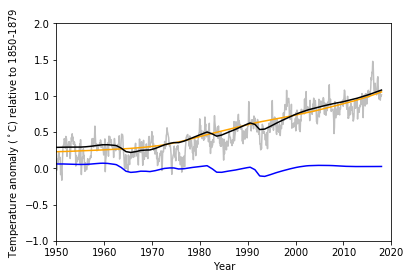

In [4]:
reg_type='mon'
base_low=1850.
base_high=1900

plt.plot(gmst['HadCRUT4']['Years'],gmst['Temp-mean'], color = 'grey', alpha = 0.5)
plt.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], color = 'orange')
plt.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-NWI'], color = 'blue')
plt.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'] + gmst['Temp-mean-NWI'], color = 'black')

plt.xlim(1950,2020)
plt.ylim(-1,2)
plt.ylabel('Temperature anomaly ($^\circ$C) relative to 1850-1879')
plt.xlabel('Year')
plt.show()